<a href="https://colab.research.google.com/github/Myavuzars/Image-Classifications-w-TensorFlow/blob/main/Bean_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import Model
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

2.4.1


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-02-27 03:17:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  93.0MB/s    in 0.9s    

2021-02-27 03:17:15 (93.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 17, 17, 768)


In [ ]:
#pre_trained_model.summary()

In [3]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print('\nReached 98% accuracy so cancelling training!')
      self.model.stop_training = True
      

In [4]:
callback= myCallback()

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
root = '/content/drive/My Drive/Colab Notebooks/Tensorflow Datasets/BEAN'

In [8]:
train_dir = os.path.join(root, 'train')
valid_dir = os.path.join(root,'validation')
test_dir = os.path.join(root,'test')
print(os.listdir(test_dir))

['angular_leaf_spot', 'bean_rust', 'healthy']


In [9]:
train_im_gen = ImageDataGenerator(rescale= 1./255,
                                   zoom_range= 0.2,
                                   width_shift_range= 0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split= 0.0)

validation_im_gen = ImageDataGenerator(rescale=1./255)

test_im_gen = ImageDataGenerator(rescale= 1./255 )


In [10]:
train_datagen= train_im_gen.flow_from_directory(train_dir,
                                             target_size= (300,300),
                                             batch_size=128,
                                             shuffle=True,
                                             class_mode='sparse' )

valid_datagen= validation_im_gen.flow_from_directory(valid_dir ,
                                             batch_size =128,
                                             class_mode='sparse',
                                             target_size= (300,300))
test_datagen = test_im_gen.flow_from_directory(test_dir,
                                               batch_size=128,
                                               class_mode='sparse',
                                               target_size= (300,300)
                                               )

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.


In [11]:
history = model.fit(
            train_datagen,
            validation_data = valid_datagen,
            steps_per_epoch = 9,
            epochs =50,
            validation_steps = 1,
            verbose = 2,
            callbacks= [callback])

Epoch 1/50
9/9 - 376s - loss: 6.3007 - accuracy: 0.4304 - val_loss: 0.6623 - val_accuracy: 0.6953
Epoch 2/50
9/9 - 25s - loss: 1.1337 - accuracy: 0.5783 - val_loss: 0.7029 - val_accuracy: 0.7188
Epoch 3/50
9/9 - 25s - loss: 1.0528 - accuracy: 0.6277 - val_loss: 0.7152 - val_accuracy: 0.7344
Epoch 4/50
9/9 - 24s - loss: 0.8010 - accuracy: 0.6915 - val_loss: 1.3707 - val_accuracy: 0.5859
Epoch 5/50
9/9 - 24s - loss: 1.0198 - accuracy: 0.6364 - val_loss: 0.6046 - val_accuracy: 0.7578
Epoch 6/50
9/9 - 24s - loss: 0.6555 - accuracy: 0.7544 - val_loss: 0.3632 - val_accuracy: 0.8984
Epoch 7/50
9/9 - 24s - loss: 0.6542 - accuracy: 0.7408 - val_loss: 1.2056 - val_accuracy: 0.5078
Epoch 8/50
9/9 - 24s - loss: 0.5313 - accuracy: 0.7805 - val_loss: 0.5371 - val_accuracy: 0.7500
Epoch 9/50
9/9 - 24s - loss: 0.6765 - accuracy: 0.7311 - val_loss: 0.3299 - val_accuracy: 0.8828
Epoch 10/50
9/9 - 25s - loss: 0.4349 - accuracy: 0.8201 - val_loss: 0.7345 - val_accuracy: 0.7031
Epoch 11/50
9/9 - 24s - loss

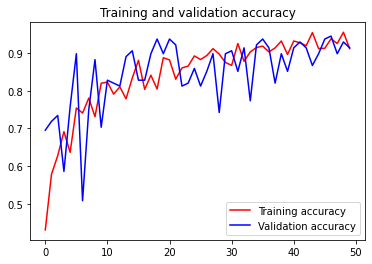

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [13]:
#Evaluate Accuracy
test_loss, test_accuracy  = model.evaluate(test_datagen, batch_size=128)

print('Accuracy on test dataset:', test_accuracy)

1/1 [==============================] - 1s 1s/step - loss: 0.1366 - accuracy: 0.9531
Accuracy on test dataset: 0.953125


In [33]:
test_images, test_labels = next(test_datagen)
predictions = model.predict(test_images)
predicts =np.argmax(model.predict(test_datagen), axis=-1)

labels= test_labels.astype(int)
print(list((labels)))
print(list(predicts))
print(len(predicts))

[2, 1, 0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0, 2, 2, 0, 1, 2, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 0, 0, 2, 0, 1, 2, 1, 2, 2, 1, 2, 1]
[2, 1, 0, 0, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 1, 1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0, 2, 2, 0, 1, 2, 1, 0, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 0, 0, 2, 0, 1, 2, 1, 2, 2, 1, 2, 1]
128


In [34]:
#Class names
def names(path):
  for dir, dirnames, filenames in os.walk(path):
    if len(dirnames) != 0:
      class_names= dirnames
  return class_names

classes = names(train_dir)
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


Requirement already up-to-date: mlxtend in /usr/local/lib/python3.7/dist-packages (0.18.0)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe776ab4190>)

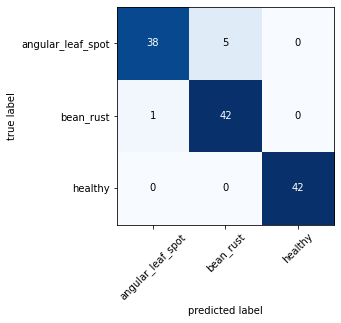

In [35]:
#Confusion Matrix
!pip install mlxtend --upgrade --no-deps 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

mat =confusion_matrix(test_labels, predicts)
plot_confusion_matrix(conf_mat=mat, class_names= classes)

In [17]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(3), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


def plot_image(i, predictions_array, true_label, images):
    predictions_array, true_label, img = predictions_array[i], true_label[i], images[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{}  {:2.0f}% ({})". format(classes[predicted_label], 100*np.max(predictions_array), classes[true_label]),
               color=color)

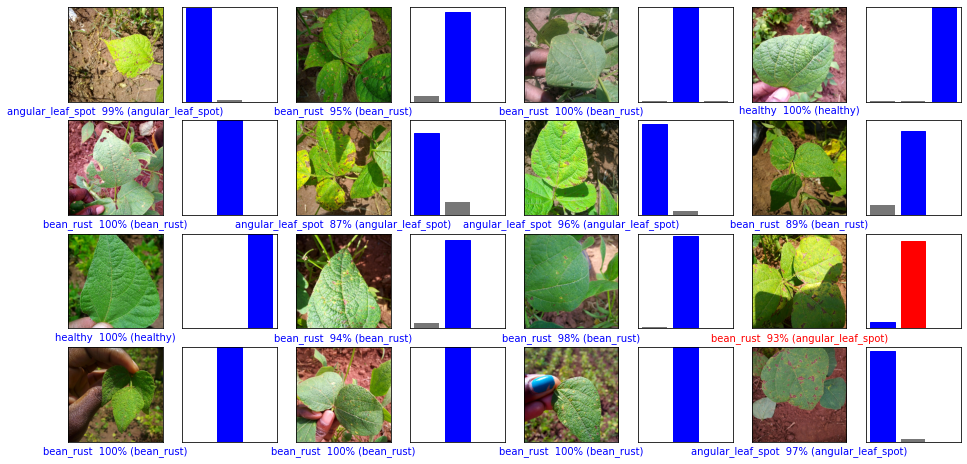

In [18]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, labels)

In [19]:
#Save Model
BEAN_MODEL= "exp_saved_model"
tf.saved_model.save(model,BEAN_MODEL)



INFO:tensorflow:Assets written to: exp_saved_model/assets


In [20]:
loaded = tf.saved_model.load(BEAN_MODEL)

In [21]:
#TFLite Model Converter

converter = tf.lite.TFLiteConverter.from_saved_model(BEAN_MODEL)



In [22]:
#Post Training Quantization
converter.optimizations =[tf.lite.Optimize.DEFAULT]

In [23]:
#Post Training Integer Quantization

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(test_images).batch(1).take(100):
    yield [input_value]

In [24]:
converter.representative_dataset = representative_data_gen

In [25]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [26]:
#Convert the Model
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

In [28]:
#Download the Model
labels= ['Angular Leaf', 'Rust Bean','Healthy']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))

try:
  from google.colab import files
  files.download('converted_model.tflite')
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>